# ScSherlock Visualization Guide: Plotting and Interpreting Results

This notebook focuses on the visualization capabilities of ScSherlock, demonstrating how to create and interpret different types of plots for marker gene analysis. ScSherlock provides a rich set of plotting functions to help you evaluate and understand marker genes identified from single-cell RNA sequencing data.

## Contents:
1. Setup and Data Preparation
2. Basic ScSherlock Run
3. Visualization Functions
   - Heatmap Visualization
   - Expression Distribution (Violin Plots)
   - Radar Plots for Multi-Metric Visualization
   - Theoretical vs. Empirical Comparison
4. Custom Visualization with ScSherlock Data
5. Exporting Plots for Publication

## 1. Setup and Data Preparation

First, let's import the necessary libraries and load a sample dataset:

In [1]:
# Import required libraries
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from typing import Dict, List

# Import ScSherlock and related classes
from scSherlock.scSherlock.scSherlock import ScSherlock, ScSherlockConfig, ScoringMethod, ParameterEstimation, AggregationMethod


In [2]:
adata = sc.read_h5ad('/home/croizer/data/hao_2021_SCT.h5ad')

adata.obs['cell_type'] = adata.obs["celltype.l3"] 
adata.obs['patient_id'] = adata.obs["donor"] 
adata.var_names_make_unique()

/home/croizer/.conda/envs/scsherlock/lib/python3.13/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


## 2. Basic ScSherlock Run

Now, let's run ScSherlock to identify marker genes that we'll visualize:

In [3]:
# Create a configuration with balanced parameters for visualization
viz_config = ScSherlockConfig(
    k_values=[1, 10, 100],
    
    # Standard scoring method
    scoring_method=ScoringMethod.DIFF,
    
    # Filtering parameters
    max_genes_kept=50,
    min_patients=2,
    min_reads=10,
    min_cells=5,
    score_cutoff=0.4,
    
    n_simulations=1000,
    n_jobs=20,
    sparse_step=20
)

In [4]:
# Initialize ScSherlock with our configuration
sherlock = ScSherlock(
    adata=adata,
    column_ctype='cell_type',
    column_patient='patient_id',
    config=viz_config
)

2025-03-26 14:48:56,787 - ScSherlock - INFO - Pre-filtering genes...
2025-03-26 14:48:56,793 - ScSherlock - INFO - ScSherlock initialized with 58 cell types and (161764, 20729) data matrix


In [5]:
# Run with theoretical method first (faster)
print("Running ScSherlock with theoretical method...")
markers_theoric = sherlock.run(method='theoric')
print(f"Found {len(markers_theoric)} marker genes using theoretical method")

2025-03-26 14:48:56,802 - ScSherlock - INFO - Calculating theoretical scores...


Running ScSherlock with theoretical method...


Aggregating Samples: 100%|███████████████████| 464/464 [00:00<00:00, 587.39it/s]
/home/croizer/scSherlock/scSherlock/scSherlock/sherlock_obj.py:532: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  n_cells = self.adata.obs.groupby(by=[self.column_ctype, self.column_patient]).size()
2025-03-26 14:48:59,288 - ScSherlock - INFO - Starting parallel processing with joblib
2025-03-26 14:49:45,321 - ScSherlock - INFO - Applying multi-category correction...
2025-03-26 14:49:45,483 - ScSherlock - INFO - Aggregating scores...
2025-03-26 14:49:45,567 - ScSherlock - INFO - Sorting scores...
2025-03-26 14:49:45,790 - ScSherlock - INFO - Identifying top markers...


Found 54 marker genes using theoretical method


In [6]:
# Run with empirical method for better visualization results
print("Running ScSherlock with empirical method...")
markers_empiric = sherlock.run(method='empiric')
print(f"Found {len(markers_empiric)} marker genes using empirical method")

2025-03-26 14:49:45,806 - ScSherlock - INFO - Skipping theorical model as it was already run. Running empiric model
2025-03-26 14:49:45,807 - ScSherlock - INFO - Filtering genes...


Running ScSherlock with empirical method...


Aggregating Samples: 100%|██████████████████████| 58/58 [00:00<00:00, 65.96it/s]
2025-03-26 14:49:48,386 - ScSherlock - INFO - Calculating empirical scores...
2025-03-26 14:49:48,387 - ScSherlock - INFO - Starting parallel empirical score calculation
2025-03-26 14:49:48,389 - ScSherlock - INFO - Computing empirical scores for 947 genes
2025-03-26 14:49:48,804 - ScSherlock - INFO - Starting parallel processing with joblib
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   13.0s
/home/croizer/.conda/envs/scsherlock/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/croizer/.conda/envs/scsherlock/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs wer

Found 37 marker genes using empirical method


In [7]:
# Get information about the identified markers
markers_df = sherlock.export_markers()
display(markers_df.head(10))

,cell_type,marker_gene,model_used,aggregated_score,theoretical_score,empirical_score,expression_proportion
0,CD14 Mono,SERPINB2,empiric,1.000000,0.408857,1.000000,1.499737e-05
1,CD8 Naive,GLIS3,empiric,0.616932,0.303962,0.616932,1.252133e-05
2,NK_2,ERFE,empiric,0.540491,0.103499,0.540491,1.712816e-06
3,CD16 Mono,DOC2B,empiric,0.916722,0.061960,0.916722,8.050387e-07
4,B intermediate lambda,PLPP3,empiric,0.431726,0.304379,0.431726,8.730258e-06
5,CD4 Naive,GPRC5B,empiric,0.699547,0.123840,0.699547,2.650503e-06
6,B naive kappa,AC108879.1,empiric,0.550780,0.042367,0.550780,6.920866e-07
7,CD4 TCM_3,TPO,empiric,0.740719,0.342583,0.740719,1.013193e-05
8,MAIT,RBM24,empiric,0.781010,0.428154,0.781010,1.964676e-05
9,gdT_3,CYP24A1,empiric,0.792812,0.183238,0.792812,3.596710e-06


## 3. Visualization Functions

Now that we have identified marker genes, let's explore the different visualization functions provided by ScSherlock:

### 3.1 Heatmap Visualization

The `plot_marker_heatmap` function creates a matrix plot showing the expression of top marker genes across all cell types. It's useful for visualizing the specificity of markers:

2025-03-26 14:51:24,157 - ScSherlock - INFO - Plotting 45 genes for 45 cell types using empiric model
/home/croizer/.conda/envs/scsherlock/lib/python3.13/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'orig.ident' as categorical
/home/croizer/.conda/envs/scsherlock/lib/python3.13/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'lane' as categorical
/home/croizer/.conda/envs/scsherlock/lib/python3.13/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'donor' as categorical
/home/croizer/.conda/envs/scsherlock/lib/python3.13/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute 

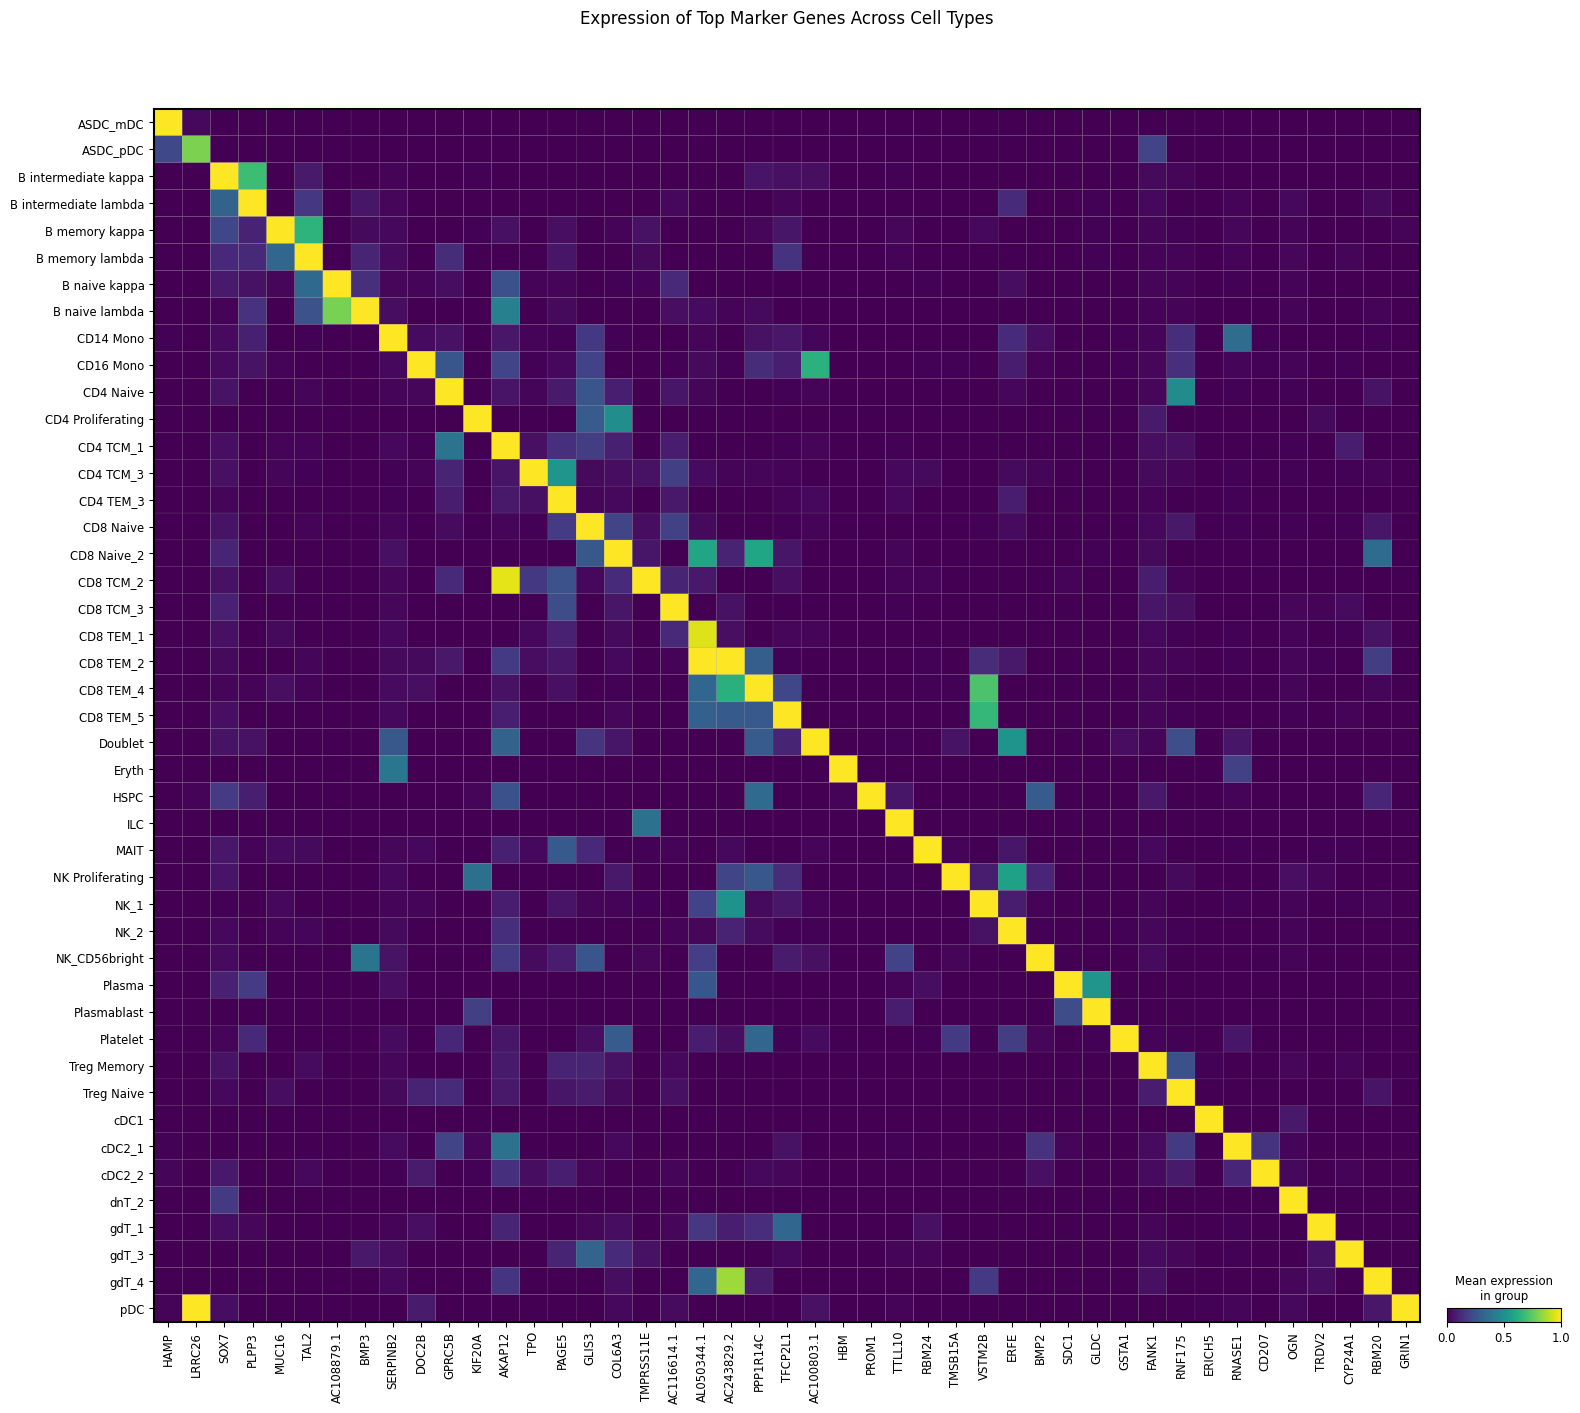

In [8]:
# Basic heatmap with default parameters - showing top marker for each cell type
sherlock.plot_marker_heatmap(
    n_genes=1,  # Number of top genes to display per cell type
    title="Expression of Top Marker Genes Across Cell Types"
)

2025-03-26 14:51:33,206 - ScSherlock - INFO - Plotting 122 genes for 45 cell types using empiric model
/home/croizer/.conda/envs/scsherlock/lib/python3.13/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'orig.ident' as categorical
/home/croizer/.conda/envs/scsherlock/lib/python3.13/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'lane' as categorical
/home/croizer/.conda/envs/scsherlock/lib/python3.13/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'donor' as categorical
/home/croizer/.conda/envs/scsherlock/lib/python3.13/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute

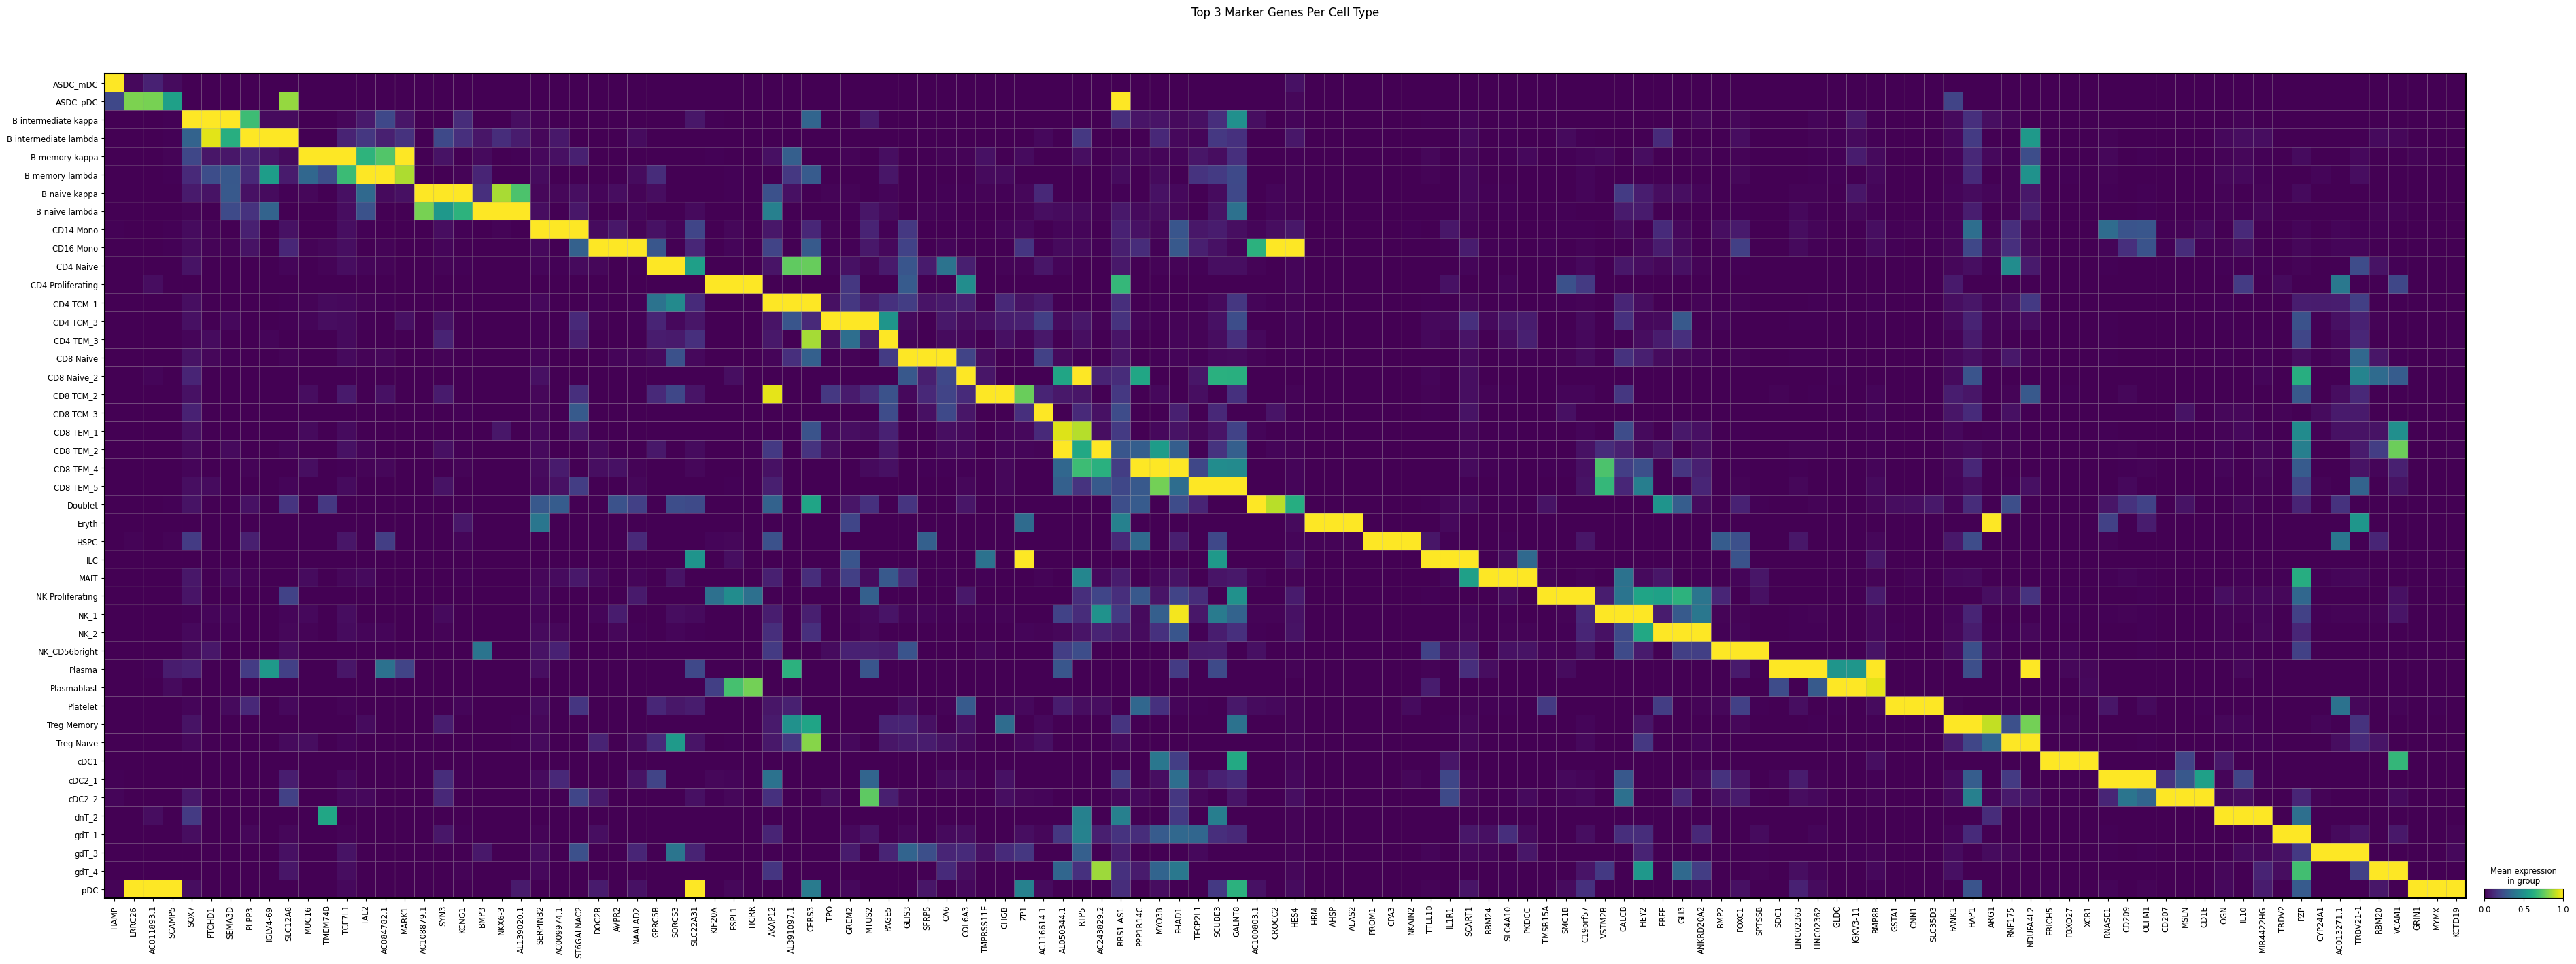

In [9]:
# Heatmap with multiple genes per cell type
sherlock.plot_marker_heatmap(
    n_genes=3,  # Show top 3 genes per cell type
    standard_scale='var',  # Scale each gene (row)
    cmap='viridis',  # Change colormap
    title="Top 3 Marker Genes Per Cell Type"
)

In [27]:
markers_df["marker_gene"].values

array(['SERPINB2', 'GLIS3', 'ERFE', 'DOC2B', 'PLPP3', 'GPRC5B',
       'AC108879.1', 'TPO', 'RBM24', 'CYP24A1', 'OGN', 'SOX7', 'MUC16',
       'AC100803.1', 'GRIN1', 'TRDV2', 'BMP3', 'TMPRSS11E', 'RNF175',
       'SDC1', 'FANK1', 'AC116614.1', 'RNASE1', 'TMSB15A', 'LRRC26',
       'TAL2', 'PROM1', 'CD207', 'GSTA1', 'BMP2', 'KIF20A', 'HBM',
       'RBM20', 'GLDC', 'ERICH5', 'HAMP', 'TTLL10'], dtype=object)

2025-03-26 14:51:40,091 - ScSherlock - INFO - Plotting 47 genes for 29 cell types using empiric model
/home/croizer/.conda/envs/scsherlock/lib/python3.13/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'orig.ident' as categorical
/home/croizer/.conda/envs/scsherlock/lib/python3.13/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'lane' as categorical
/home/croizer/.conda/envs/scsherlock/lib/python3.13/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'donor' as categorical
/home/croizer/.conda/envs/scsherlock/lib/python3.13/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute 

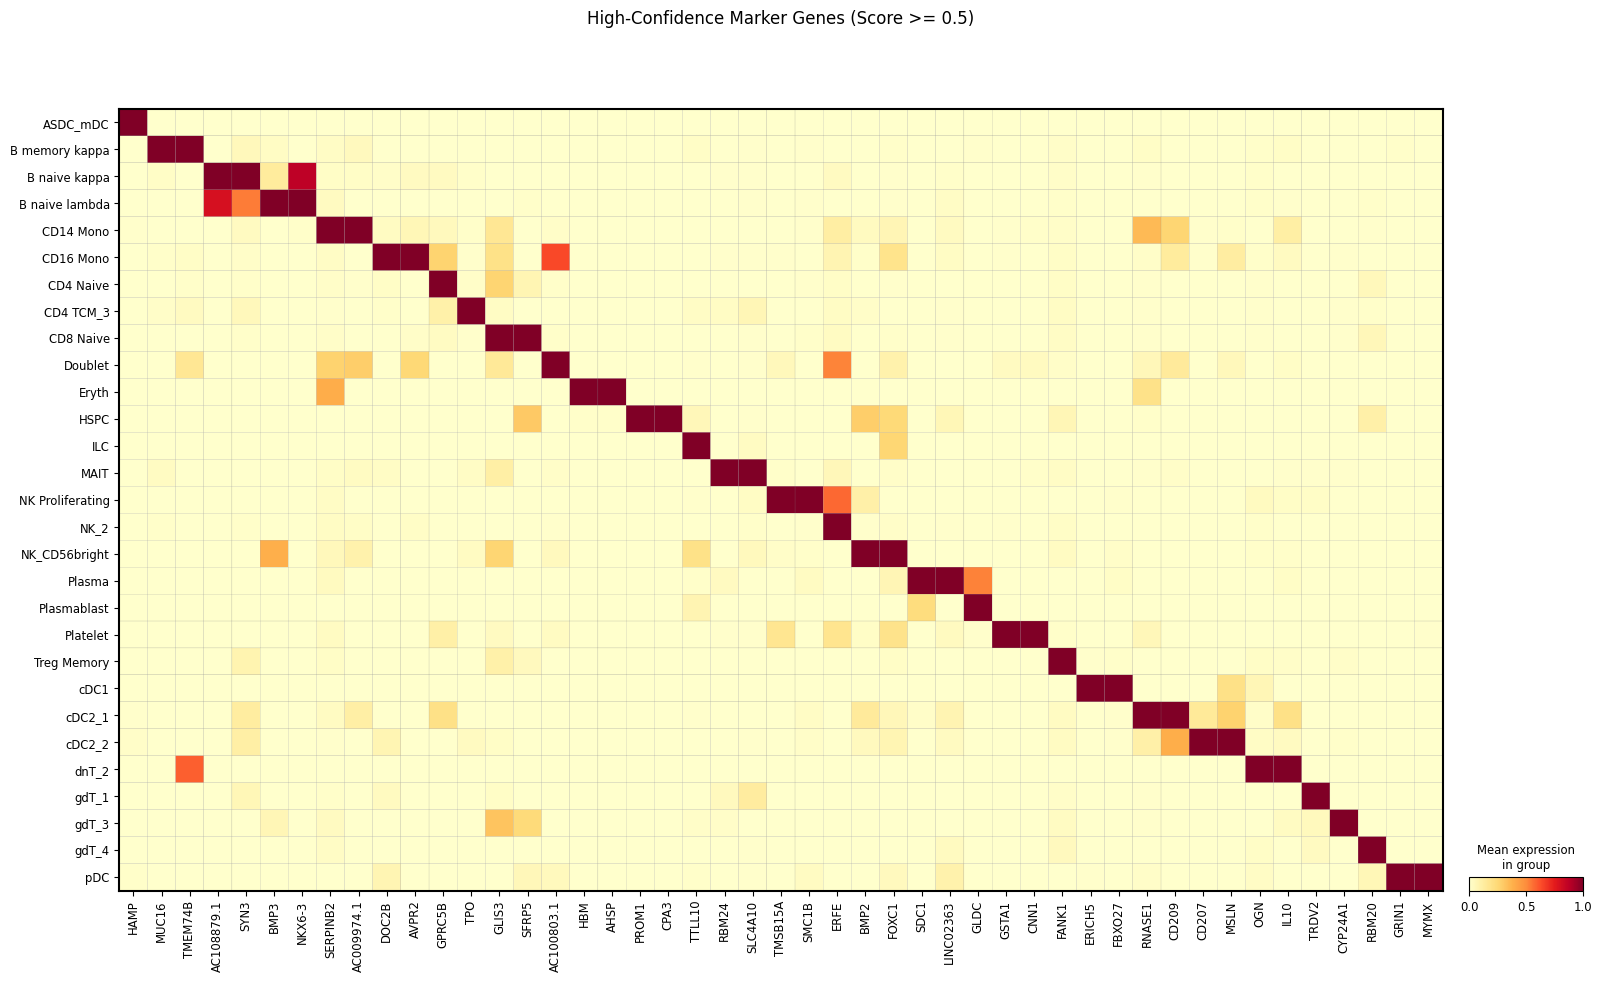

In [10]:
# Customizing the heatmap further
sherlock.plot_marker_heatmap(
    n_genes=2,  # Show top 2 genes per cell type
    cutoff=0.5,  # Only include genes with score >= 0.5
    standard_scale='var',  # Scale each gene (row)
    cmap='YlOrRd',  # Change colormap
    title="High-Confidence Marker Genes (Score >= 0.5)"
)

### 3.2 Expression Distribution (Violin Plots)

The `plot_marker_violins` function creates violin plots showing the expression distribution of marker genes across cell types. This visualizes not just the mean expression but the full distribution, revealing important nuances:

KeyError: "Could not find keys ['SERPINB2'] in columns of `adata.obs` or in adata.raw.var_names."

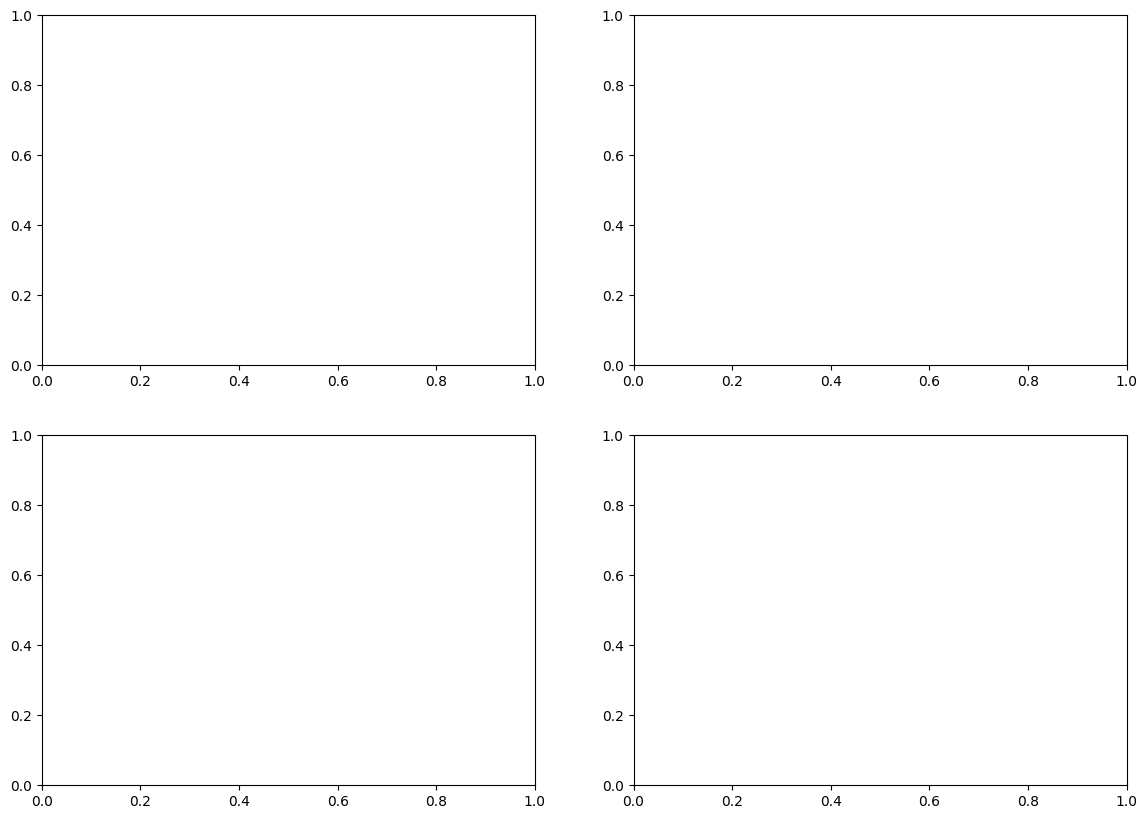

In [17]:
# Basic violin plots for top markers
if hasattr(sherlock, 'plot_marker_violins'):
    fig = sherlock.plot_marker_violins(
        n_markers=4,  # Show top 4 markers
        figsize=(14, 10)
    )
else:
    # Alternative approach if the method isn't available
    top_markers = list(markers_empiric.values())[:4]
    sc.pl.violin(adata, top_markers, groupby='cell_type', ncols=2, figsize=(14, 10))

KeyError: "Could not find keys ['SERPINB2'] in columns of `adata.obs` or in adata.raw.var_names."

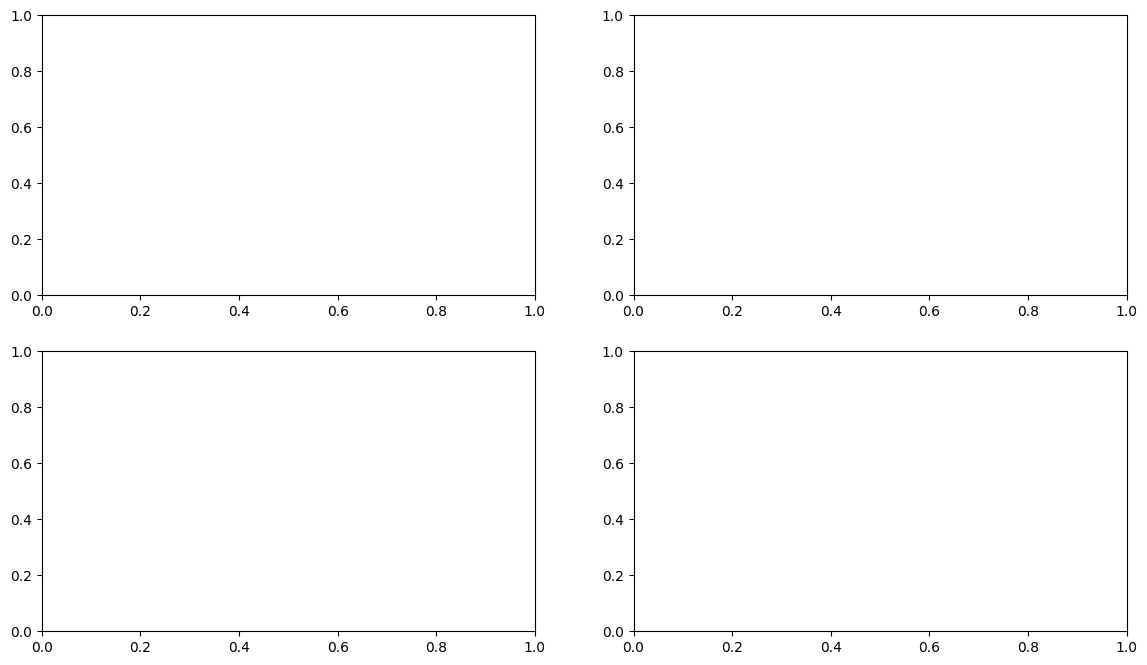

In [ ]:
# Customized violin plots
if hasattr(sherlock, 'plot_marker_violins'):
    fig = sherlock.plot_marker_violins(
        n_markers=3,  # Show top 3 markers
        figsize=(14, 8),
        jitter=0.4,  # Add jitter to data points
        alpha=0.3,  # Transparency of points
        sort_by_expression=True  # Sort cell types by median expression
    )
else:
    # Alternative approach
    top_markers = list(markers_empiric.values())[:3]
    sc.pl.violin(adata, top_markers, groupby='cell_type', ncols=2, figsize=(14, 8), jitter=0.4)

### 3.5 Radar Plots for Multi-Metric Visualization

The `plot_marker_radar` function creates radar charts visualizing multiple metrics for top marker genes:

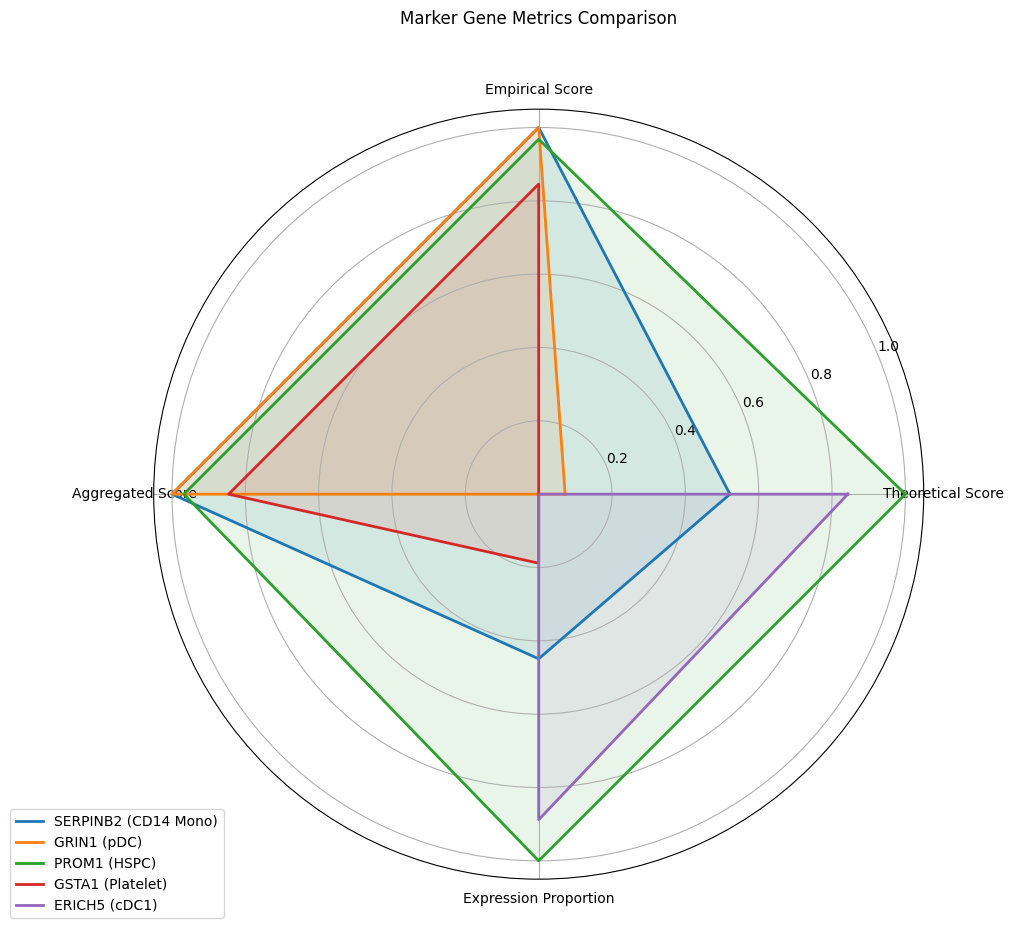

In [ ]:
# Create radar plot for top markers
if hasattr(sherlock, 'plot_marker_radar'):
    fig = sherlock.plot_marker_radar(
        n_markers=5,  # Show top 5 markers
        figsize=(10, 10)
    )
else:
    # Alternative radar plot implementation
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get top markers
    markers_top = markers_df.sort_values('aggregated_score', ascending=False).head(5)
    
    # Define metrics to include
    metrics = ['theoretical_score', 'empirical_score', 'aggregated_score', 'expression_proportion']
    metric_labels = ['Theoretical Score', 'Empirical Score', 'Aggregated Score', 'Expression Proportion']
    
    # Normalize metrics to 0-1 scale
    markers_norm = markers_top.copy()
    for metric in metrics:
        if metric in markers_norm.columns and not markers_norm[metric].isna().all():
            markers_norm[metric] = (markers_norm[metric] - markers_norm[metric].min()) / \
                                  (markers_norm[metric].max() - markers_norm[metric].min() + 1e-10)
    
    # Create radar plot
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    
    # Calculate angles for radar plot
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    # Add metric labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels)
    
    # Plot each marker
    for _, row in markers_norm.iterrows():
        values = [row[metric] if metric in row and not np.isnan(row[metric]) else 0 for metric in metrics]
        values += values[:1]  # Close the loop
        
        ax.plot(angles, values, linewidth=2, label=f"{row['marker_gene']} ({row['cell_type']})")
        ax.fill(angles, values, alpha=0.1)
    
    ax.set_title('Marker Gene Metrics Comparison', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.show()

**What to look for in radar plots:**

* **Balance across metrics**: Ideal markers score well across all dimensions.
* **Strengths and weaknesses**: Some markers may excel in certain metrics but underperform in others.
* **Complementary markers**: Different markers may have complementary profiles, suggesting they could be used together.
* **Cell type patterns**: Markers for the same cell type may share similar metric profiles.

### 3.6 Theoretical vs. Empirical Comparison

The `plot_theoretical_vs_empirical` function creates plots comparing theoretical and empirical scores for marker genes:

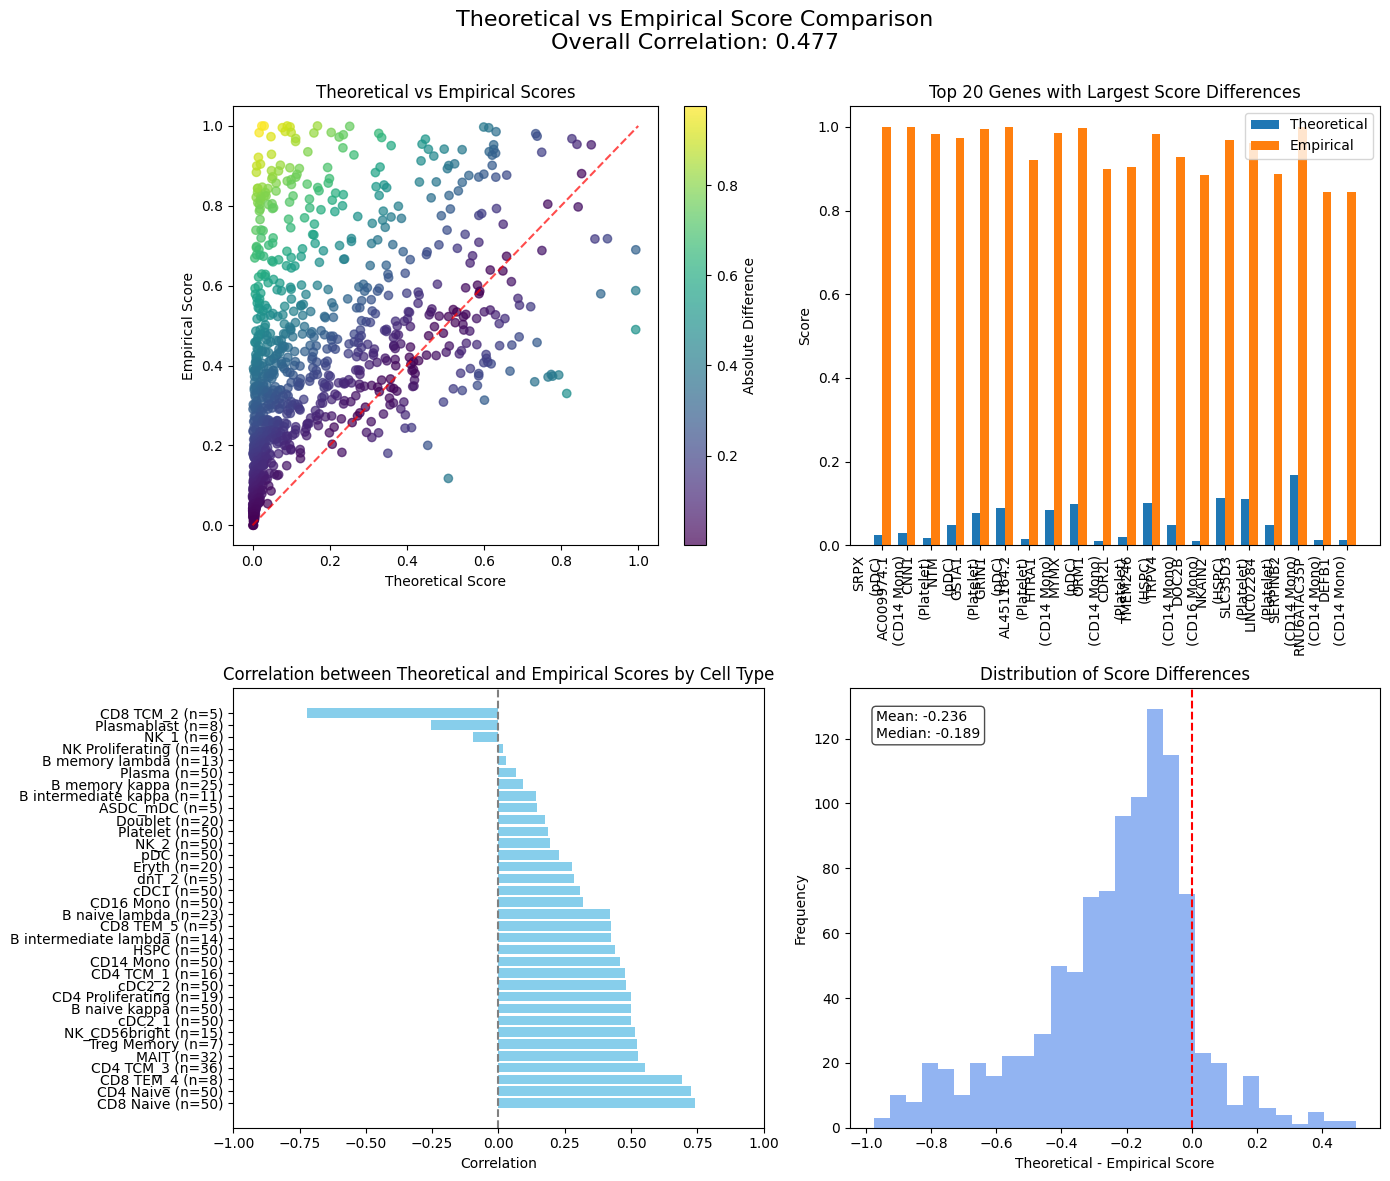

In [ ]:
# Compare theoretical and empirical scores
if hasattr(sherlock, 'plot_theoretical_vs_empirical'):
    fig = sherlock.plot_theoretical_vs_empirical(
        n_genes=20,  # Number of genes to include
        figsize=(14, 12)
    )
else:
    # Simple alternative comparison
    if 'empirical_score' in markers_df.columns and not markers_df['empirical_score'].isna().all():
        plt.figure(figsize=(8, 8))
        plt.scatter(markers_df['theoretical_score'], markers_df['empirical_score'], alpha=0.7)
        plt.plot([0, 1], [0, 1], 'r--', alpha=0.7)  # Diagonal line
        
        plt.xlabel('Theoretical Score')
        plt.ylabel('Empirical Score')
        plt.title('Theoretical vs Empirical Scores')
        
        # Calculate correlation
        corr = np.corrcoef(markers_df['theoretical_score'], markers_df['empirical_score'])[0, 1]
        plt.text(0.05, 0.95, f"Correlation: {corr:.3f}", transform=plt.gca().transAxes)
        
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.grid(alpha=0.3)
        plt.show()

## 4. Custom Visualization with ScSherlock Data

Beyond the built-in functions, you can create custom visualizations using the ScSherlock results:

In [ ]:
# Get marker information
markers_export = sherlock.export_markers()

# Get top 5 markers
top_markers = markers_export.sort_values('aggregated_score', ascending=False).head(5)
display(top_markers)

,cell_type,marker_gene,model_used,aggregated_score,theoretical_score,empirical_score,expression_proportion
0,CD14 Mono,SERPINB2,empiric,1.000000,0.168418,1.000000,0.000015
14,pDC,GRIN1,empiric,1.000000,0.089924,1.000000,0.000007
27,HSPC,PROM1,empiric,0.999109,0.252004,0.999109,0.000025
29,Platelet,GSTA1,empiric,0.995726,0.077318,0.995726,0.000010
36,cDC1,ERICH5,empiric,0.972305,0.224579,0.972305,0.000023


In [30]:
# Create a custom plot: UMAP with marker gene expression
if len(top_markers) > 0:
    # Get the top marker gene
    top_gene = top_markers.iloc[0]['marker_gene']
    top_ctype = top_markers.iloc[0]['cell_type']
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: UMAP colored by cell type
    sc.pl.umap(adata, color='cell_type', legend_loc='on data', title=f'Cell Types (Marker: {top_gene})', ax=ax1, show=False)
    
    # Plot 2: UMAP colored by marker gene expression
    sc.pl.umap(adata, color=top_gene, title=f'Expression of {top_gene} (Marker for {top_ctype})', ax=ax2, show=False)
    
    plt.tight_layout()
    plt.show()

NameError: name 'top_markers' is not defined

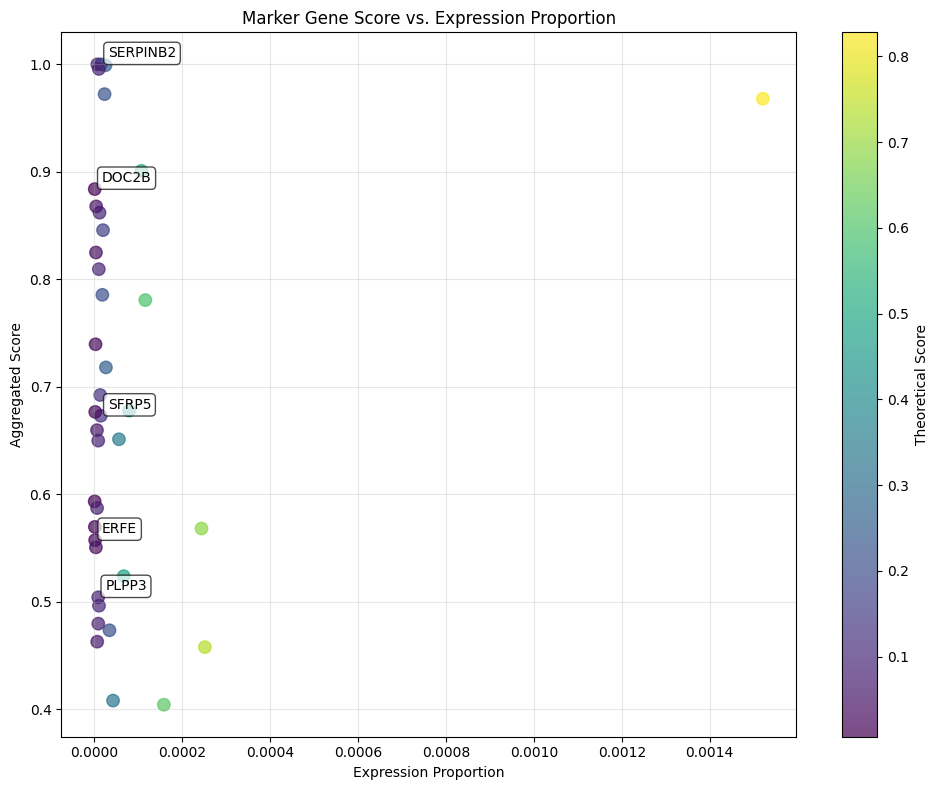

In [ ]:
# Custom visualization: Score vs. Expression scatter plot
if len(markers_export) > 0:
    plt.figure(figsize=(10, 8))
    
    # Create a scatter plot of score vs. expression proportion
    scatter = plt.scatter(
        markers_export['expression_proportion'], 
        markers_export['aggregated_score'],
        c=markers_export['theoretical_score'] if 'theoretical_score' in markers_export.columns else None,
        alpha=0.7,
        s=80,
        cmap='viridis'
    )
    
    # Add a colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Theoretical Score')
    
    # Add labels for top markers
    for idx, row in markers_export.head(5).iterrows():
        plt.annotate(
            row['marker_gene'],
            (row['expression_proportion'], row['aggregated_score']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7)
        )
    
    plt.xlabel('Expression Proportion')
    plt.ylabel('Aggregated Score')
    plt.title('Marker Gene Score vs. Expression Proportion')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## 5. Exporting Plots for Publication

You can save these visualizations for publication or reports:

2025-03-26 14:08:46,957 - ScSherlock - INFO - Plotting 94 genes for 49 cell types using empiric model
/tmp/ipykernel_3328376/1062940061.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x1000 with 0 Axes>

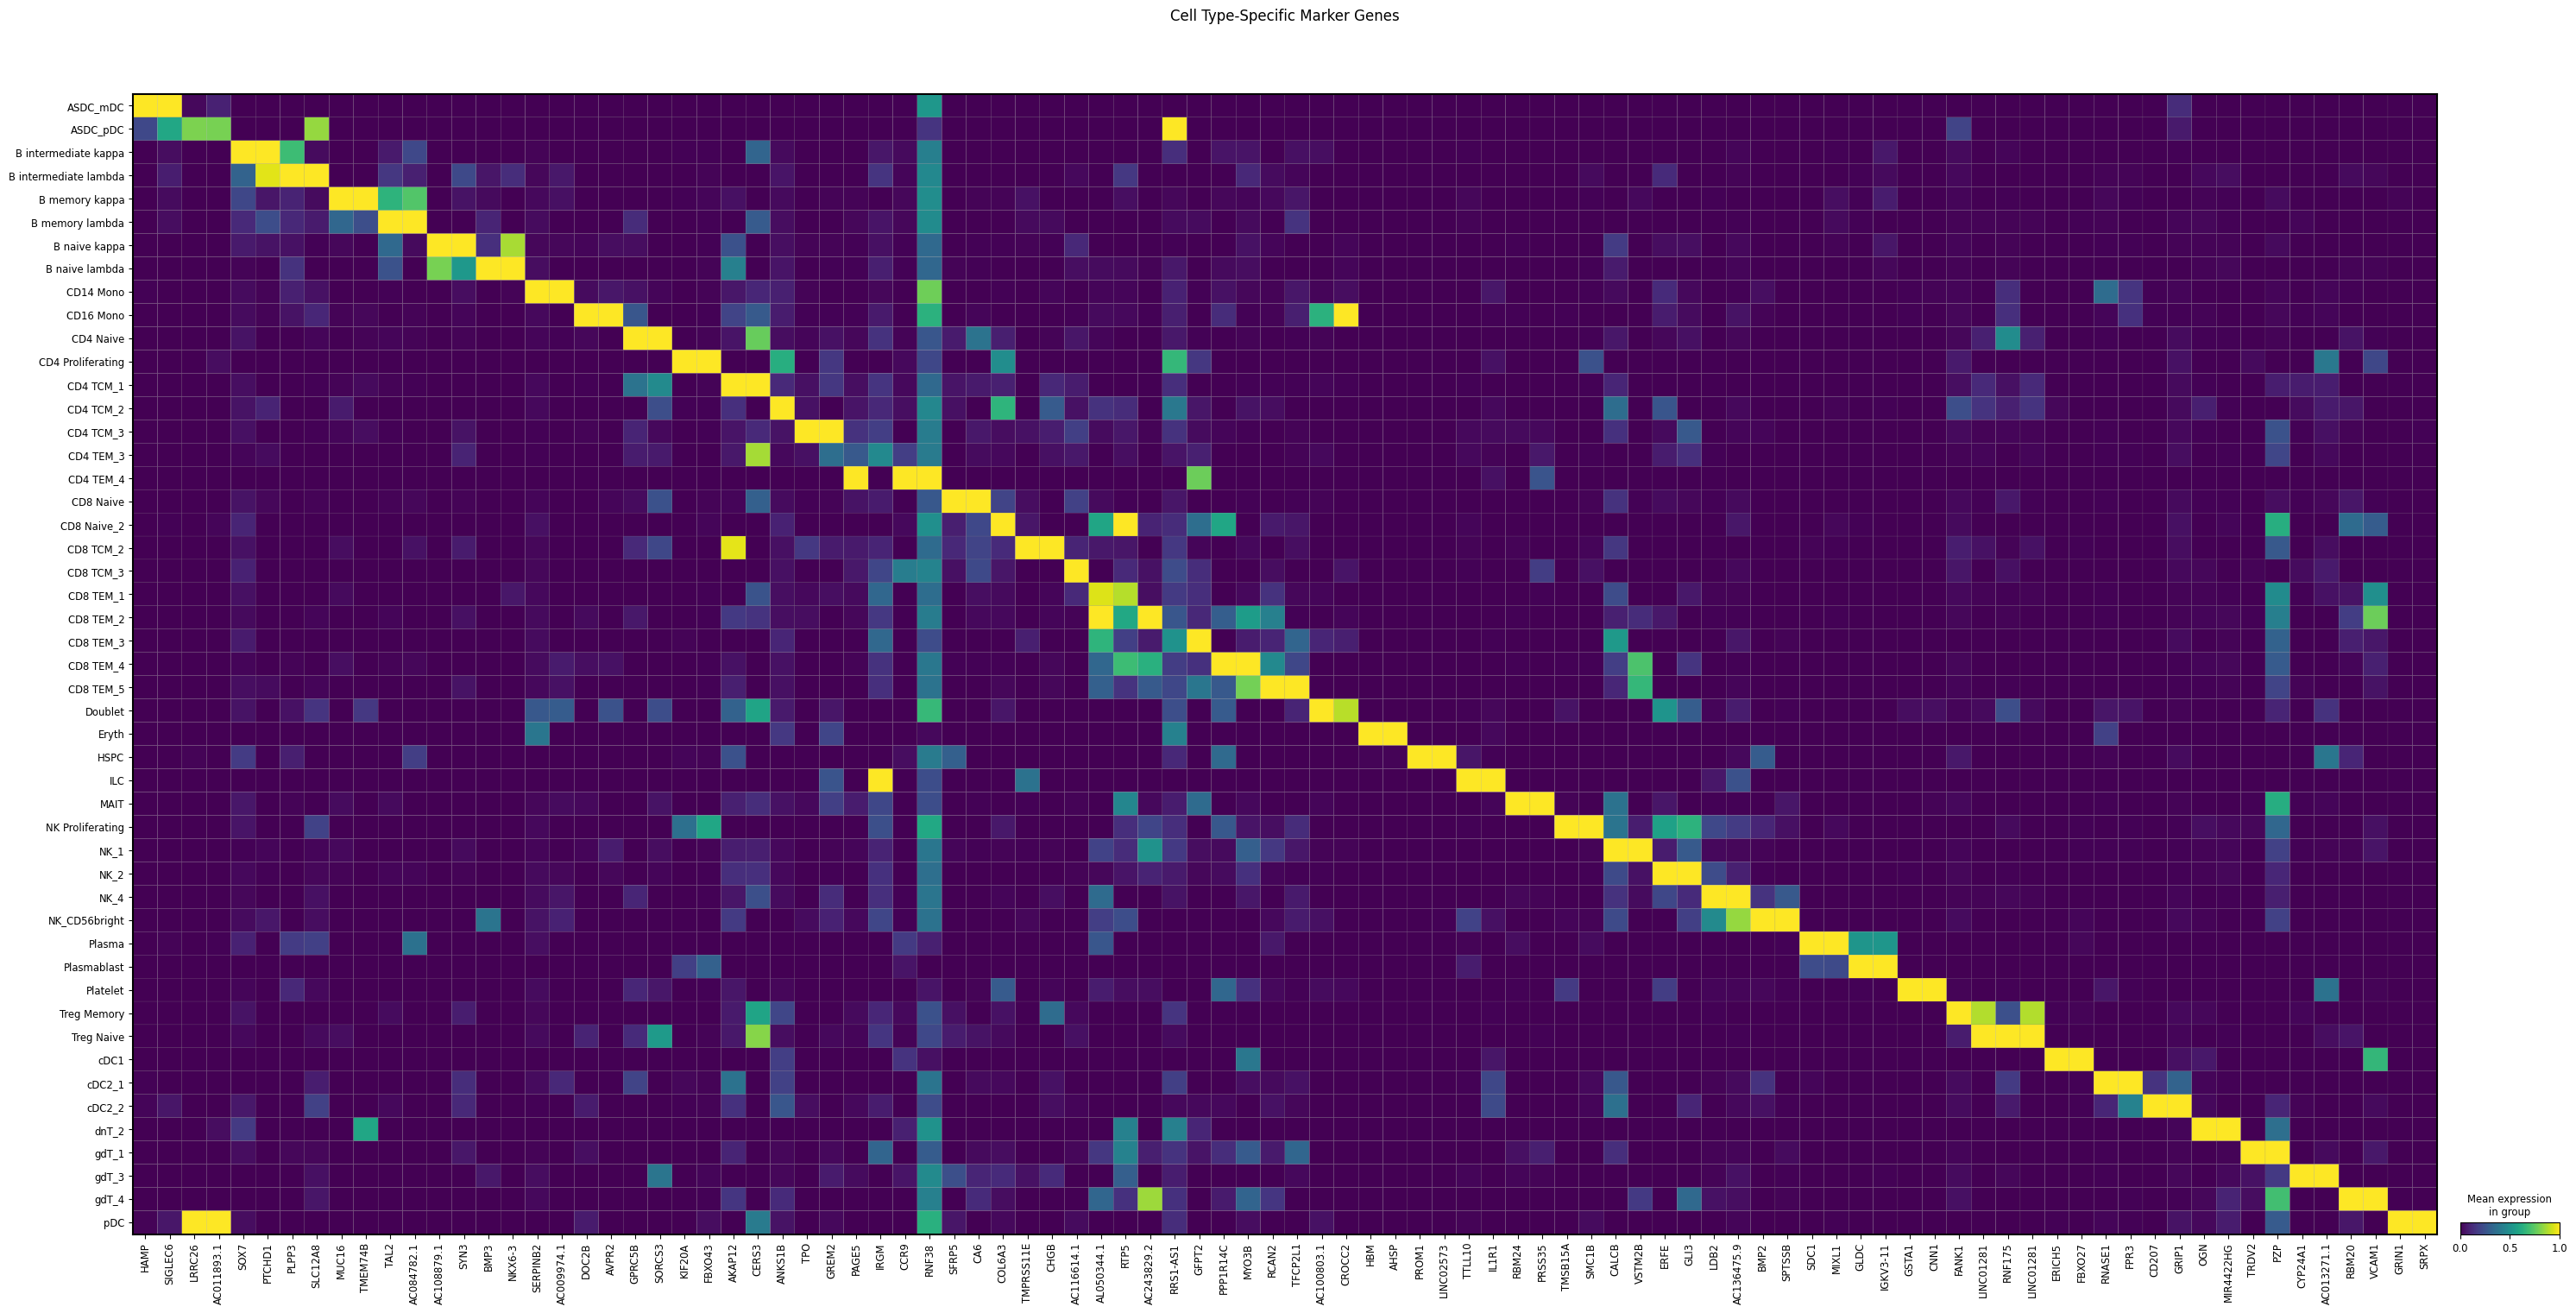

In [ ]:
# Create a high-quality heatmap and save it
plt.figure(figsize=(12, 10))

# Create the heatmap
heatmap_fig = sherlock.plot_marker_heatmap(
    n_genes=2, 
    cmap='viridis',
    standard_scale='var',
    title="Cell Type-Specific Marker Genes",
    show=False  # Don't display yet
)

# Save the figure (uncomment to save)
# heatmap_fig.figure.savefig('scsherlock_marker_heatmap.png', dpi=300, bbox_inches='tight')
# heatmap_fig.figure.savefig('scsherlock_marker_heatmap.pdf', format='pdf', bbox_inches='tight')

# Now display the figure
plt.tight_layout()
plt.show()

## 6. Summary and Visualization Selection Guide

Here's a quick reference guide for choosing the right visualization based on your analytical goal:

| Goal | Recommended Visualization | Key Insights |
|------|---------------------------|-------------|
| **Overall marker specificity** | Heatmap (`plot_marker_heatmap`) | Expression patterns across all cell types |
| **Expression distribution details** | Violin plots (`plot_marker_violins`) | Full distribution, outliers, bimodality |
| **Multi-metric evaluation** | Radar plots (`plot_marker_radar`) | Balance across different quality metrics |
| **Model validation** | Theoretical vs. empirical (`plot_theoretical_vs_empirical`) | Assess how well theoretical model matches simulation |
| **Spatial context** | UMAP with gene expression | Visualize marker expression in low-dimensional space |
| **Cell type quality assessment** | Custom score distribution plots | Compare ease of finding markers across cell types |

By combining these visualizations, you can thoroughly evaluate marker genes and gain confidence in your cell type marker selection.